## RepeatedCustomers-TimeSeries-Analysis-Predictions-and-Forecasting-using-AR-and-BIC
Task: to repeated customers predictions and forecastings
Hypothesis: to check for the existence of stationary in the time series dataset
Method of forecasting: 'BIC' and univariate autoregressive algorithm
Data Source: UCI dataset - 'online_retail_II.csv'

- Systmes and libraries setup
- Data Load
- Exploratory Analysis
  - product and customer analysis for mising values, filtering and outliers
- Time Series Analysis, hypothesis evaluations, explainable predictions and forecasting workflow
  - Analysis/hypothesis evaluations, features extractions, explainable predictions/forecasting workflow, and performance       testing 

In [1]:
# Systems and libraries setup

# import data structure libaries
import pandas as pd
import numpy as np

# import statistical and hypothesis testing libraries
from scipy import stats
import scipy.stats

# import visualisations libraries
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

#set fiqure size to control all plt plottings
plt.rcParams['figure.figsize']=(10,7)


In [26]:
#Data Load  

r_df = pd.read_csv('online_retail_II.csv')
r_df = r_df.dropna()
print(r_df.shape)
r_df.head(2)   # print sample frame by rows



(824364, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


## Exploratory Analysis
customer and product order quantities data explorations
  - missing customers checks - if any missing value delete related records
  - filtering customers without negative quantities- extract only customers with product qty greater than zero
  - outlier checks on customers using interquartile range: if any remove outliers data points

In [28]:
# rename columns to make it more meaningful
r_df = r_df.rename(columns = {"Invoice" :"InvoiceNo", "Price" : "UnitPrice"})
                                                  

Missing value found: 0


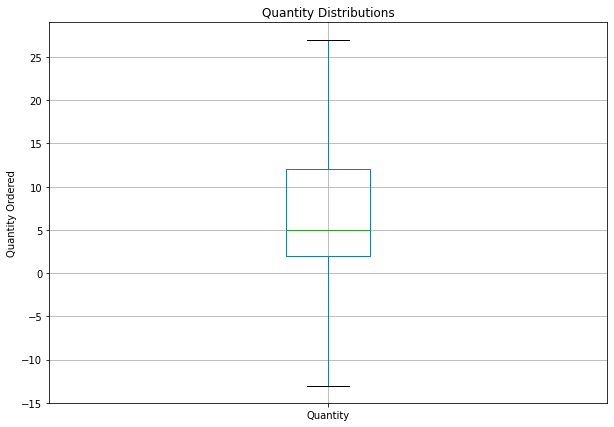

In [29]:
# missing customers checks - if any missing value delete related records
missing_value_chks = r_df['Customer ID'].isna().sum()
print('Missing value found:',(missing_value_chks))

# output explanation:
# returned 0 because no missing value on customerID

# visualise quantity of order distributions by all variables
ax = r_df[['Quantity']].boxplot(
    showfliers = False, figsize = (10,7)
    )

ax.set_ylabel('Quantity Ordered')
ax.set_title('Quantity Distributions')

plt.show()

# explanation:
# existence of negative orders

plt.show()

filtered data size without negative stocks:  (805620, 8)
Unfiltered data size with negative stocks: (824364, 8)


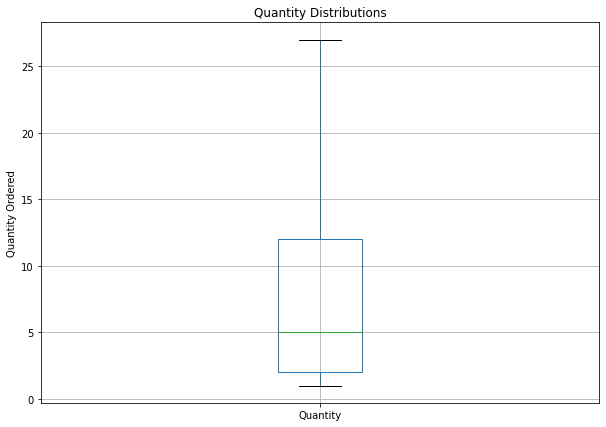

In [30]:
# filtering customers without negative quantities- extract only customers with product qty greater than zero
r1_df = r_df.loc[r_df['Quantity'] > 0]
print('filtered data size without negative stocks: ', (r1_df.shape))  # filtered data
print('Unfiltered data size with negative stocks:', (r_df.shape))   # original data


# visualise quantity of order distributions by all variables
ax = r1_df[['Quantity']].boxplot(
    showfliers = False, figsize = (10,7)
    )

ax.set_ylabel('Quantity Ordered')
ax.set_title('Quantity Distributions')

plt.show()

# explanation:
# no negative orders
plt.show()


AxesSubplot(0.125,0.125;0.775x0.755)


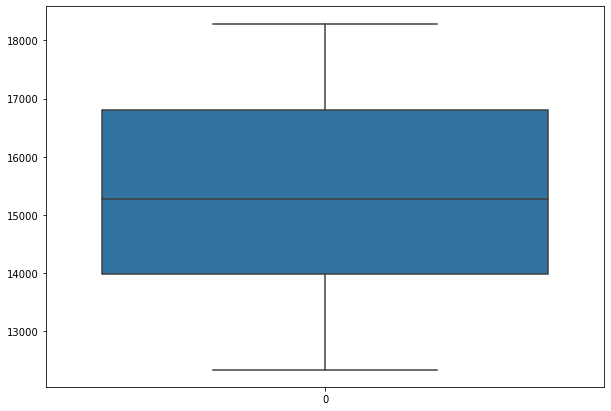

In [31]:
# outlier checks on customers using interquartile range: if any remove outliers data points

outlier_chks =sns.boxplot(data = r1_df['Customer ID'])
print(outlier_chks)

#  output explanation:
# no outlier detected, since there are no data points outside the interquartile range

 ## Time Series Analysis
 Time Series Analysis, hypothesis evaluations, explainable predictions and forecasting workflow
  - Conversions
  - Data argumentations 
  - Analysis/hypothesis evaluations
  - features extractions repeated customers
  - explainable predictions/forecasting workflow, and performance testing 

In [60]:
# Data conversions

# convert unitprice and qty to sales
r1_df.loc[:,'Sales'] = r1_df['Quantity'] * r1_df['UnitPrice']

# convert to datetime
r1_df.loc[:,'InvoiceDate'] = pd.to_datetime(r1_df['InvoiceDate'])

# first convert date to month to see unique purchase 
orders_df_by_months = r1_df.set_index('InvoiceDate')['InvoiceNo'].resample('M').nunique()
print(orders_df_by_months.head(2))


InvoiceDate
2009-12-31    1512
2010-01-31    1011
Freq: M, Name: InvoiceNo, dtype: int64


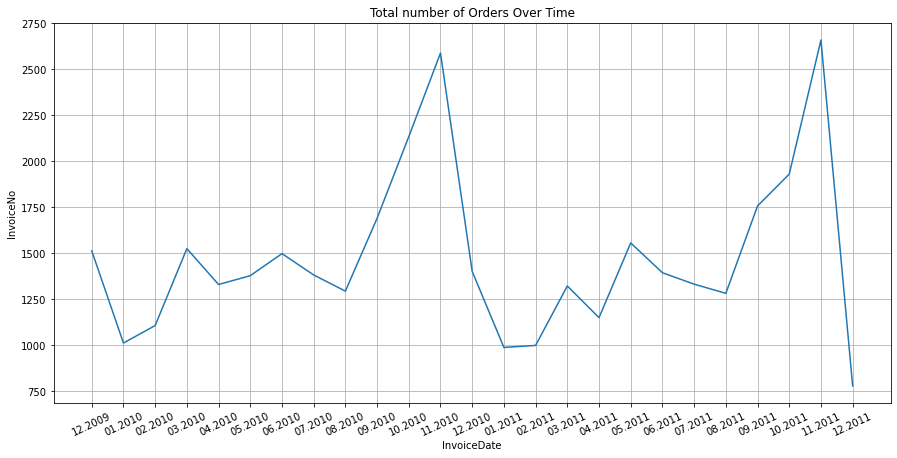

In [61]:
# visualisation
ax = pd.DataFrame(orders_df_by_months.values).plot(
    grid = True, 
    figsize = (15,7),
    legend = False
)

ax.set_xlabel('InvoiceDate')
ax.set_ylabel('InvoiceNo')
ax.set_title('Total number of Orders Over Time')

plt.xticks(
    range(len(orders_df_by_months.index)),
    [x.strftime('%m.%Y') for x in orders_df_by_months.index],
    rotation = 25   # x labels position
)

plt.show()

In [62]:
# looking at the exact month details with min or and max number of invoices

inv_date = r1_df.loc[
    r1_df['InvoiceDate'] >= '2009-12-01', 'InvoiceDate'
]
print('Min date: %s\nMax date: %s' % (inv_date.min(), inv_date.max()))


Min date: 2009-12-01 07:45:00
Max date: 2011-12-09 12:50:00


In [64]:
# data argumentations/ features extractions and repeated customers invoice extractions

# first aggregate by repeated invoice
customer_by_inv_df= r1_df.groupby(
    by= ['InvoiceNo', 'InvoiceDate']
).agg(
    {'Sales': sum,
    'Customer ID': max,
    'Country':max}
).reset_index()

customer_by_inv_df.head(5)

# repeated customers by months
repeat_cust_by_months_df = customer_by_inv_df.set_index('InvoiceDate').groupby([
   pd.Grouper(freq='M'),'Customer ID']).filter(lambda x: len(x) >1).resample('M').nunique()['Customer ID']
print(repeat_cust_by_months_df.head(3))

# unique customers by months
unique_cust_by_months_df = r1_df.set_index('InvoiceDate')['Customer ID'].resample('M').nunique()
print(unique_cust_by_months_df.head(3))


InvoiceDate
2009-12-31    286
2010-01-31    148
2010-02-28    175
Freq: M, Name: Customer ID, dtype: int64
InvoiceDate
2009-12-31    955
2010-01-31    720
2010-02-28    774
Freq: M, Name: Customer ID, dtype: int64


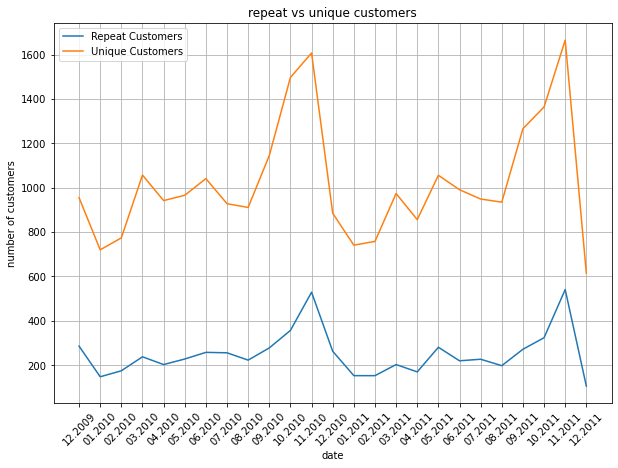

In [66]:
# visualisations of Repeat vs Unique Customers
ax = pd.DataFrame(repeat_cust_by_months_df.values).plot(
    figsize = (10,7)
)

pd.DataFrame(unique_cust_by_months_df.values).plot(
    ax = ax, grid = True
)

ax.set_xlabel('date')
ax.set_ylabel('number of customers')
ax.set_title('repeat vs unique customers')

ax.legend(['Repeat Customers', 'Unique Customers'])

plt.xticks(
    range(len(repeat_cust_by_months_df.index)),
    [x.strftime('%m.%Y') for x in repeat_cust_by_months_df.index],
    rotation = 45
)

plt.show()



             Customer ID
InvoiceDate             
2009-12-31           286
2010-01-31           148
2010-02-28           175


(25, 1)

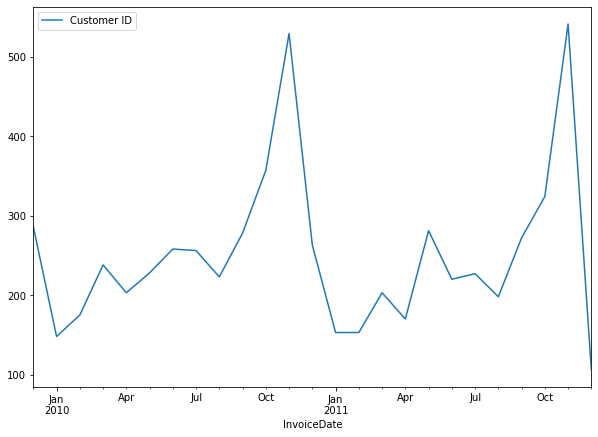

In [91]:
# Features extractions: repeated customers by months

repeat_cust_by_months_df1 = pd.DataFrame(repeat_cust_by_months_df)
repeat_cust_by_months_ts = repeat_cust_by_months_df1.asfreq(pd.infer_freq(repeat_cust_by_months_df1.index))

print(repeat_cust_by_months_ts.head(3))

# examing the time series plot to check for stationarity, seasonlity, cyclicity
repeat_cust_by_months_ts.plot()
repeat_cust_by_months_ts.shape

In [214]:
# Further proof of stationarity data at 0.05 confidence interval
# ADF is a unit root test for stationarity of a time series
# H0: there is a unit root for the existence of stationary on the repeated customer series data
# H1: there is no unit root

from statsmodels.tsa.stattools import adfuller

ar_lag = adfuller(repeat_cust_by_months_ts['Customer ID'], autolag = 'BIC')
#print(ar_lag)

ar_lagg= np.array(ar_lag)
ar_lagg= pd.DataFrame(nn1)
ar_lagg = nn2.T.rename(columns = {0: 'ADF', 1: 'p_values', 2: 'Lags', 3: 'Observations', 4: 'Critical Values'})
ar_lagg = ar_lagg[['ADF','p_values','Lags','Observations']]
ar_lagg
# output explanation
# - since p-value is less than 0.05, the alternate hypothesis is rejected
# - Hence the repeated customers time series is stationary, and can be used for forecasting

,ADF,p_values,Lags,Observations
0,-3.8257,0.00265501,0,24


In [215]:
#create train and test data

#create train sets
start_date = pd.to_datetime('2009-12-01')
end_date = pd.to_datetime('2011-03-01')
train_data = repeat_cust_by_months_ts[start_date: end_date ]

# index train sets
#train_data = train_dataset.asfreq(pd.infer_freq(train_dataset.index))

#create test sets
test_start_date = len(train_data)
test_end_date = len(repeat_cust_by_months_ts) -1

test_data = repeat_cust_by_months_ts[test_start_date: ]

print(train_data.shape)
test_data.head()


(15, 1)


,Customer ID
InvoiceDate,
2011-03-31,203
2011-04-30,170
2011-05-31,281
2011-06-30,220
2011-07-31,227


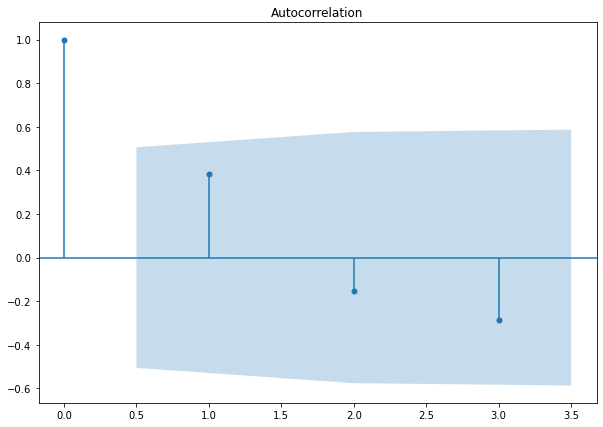

In [216]:
# model analyse autocorelation lags
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(train_data['Customer ID'], lags=3)

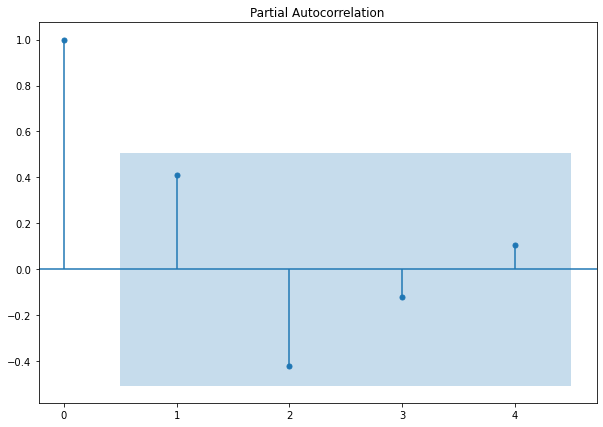

In [131]:
pacf_plt = plot_pacf(train_data['Customer ID'], lags = 4)

In [217]:
# model and extract correlation coefficients
from statsmodels.tsa.ar_model import AutoReg
from time import time

start =time()
ar_mdl = AutoReg(train_data['Customer ID'], lags =3, seasonal=False, old_names = True).fit()
end = time()
print('ar_mdl model training time:', end - start)
print(ar_mdl.summary())

# output explanations
#lag variables less than 0.05 shows strong correlations to the predicted model

ar_mdl model training time: 0.007980823516845703
                            AutoReg Model Results                             
Dep. Variable:            Customer ID   No. Observations:                   15
Model:                     AutoReg(3)   Log Likelihood                 -69.573
Method:               Conditional MLE   S.D. of innovations             79.741
Date:                Thu, 28 Jan 2021   AIC                              9.591
Time:                        11:30:59   BIC                              9.793
Sample:                    03-31-2010   HQIC                             9.516
                         - 02-28-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        250.3240    104.114      2.404      0.016      46.263     454.385
Customer ID.L1     0.5150      0.290      1.778      0.075      -0.053

In [171]:
# 10 months prediction from test data
predicted = ar_mdl.predict(start=len(train_data), end =len(repeat_cust_by_months_ts)-1, dynamic=False)

# convert to dataframe
predicted_10 = pd.DataFrame(predicted).rename(columns ={0: 'Predicted Repeated Customers'})
print("10 Months Repeated Customers Prediction:\n", (predicted_10))
len(predicted)

10 Months Repeated Customers Prediction:
             Predicted Repeated Customers
2011-03-31                    241.095644
2011-04-30                    302.278756
2011-05-31                    304.875615
2011-06-30                    273.468218
2011-07-31                    247.645295
2011-08-31                    244.280874
2011-09-30                    255.538330
2011-10-31                    266.152471
2011-11-30                    268.407804
2011-12-31                    264.467403


10

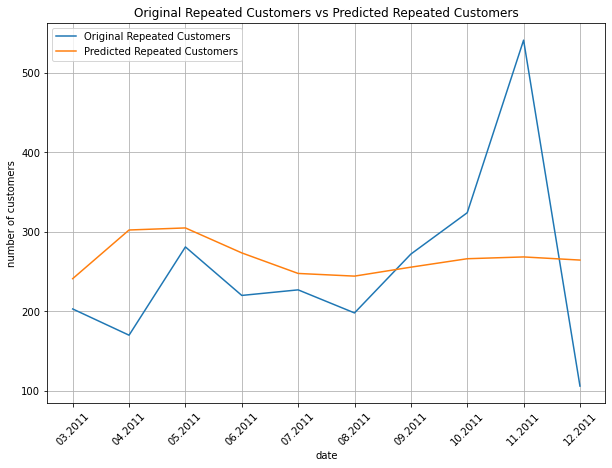

In [134]:
# 'Original Repeated Customers vs Predicted Repeated Customers'
ax = pd.DataFrame(test_data.values).plot(
    figsize = (10,7)
)

pd.DataFrame(predicted.values).plot(
    ax = ax, grid = True
)

ax.set_xlabel('date')
ax.set_ylabel('number of customers')
ax.set_title('Original Repeated Customers vs Predicted Repeated Customers')

ax.legend(['Original Repeated Customers', 'Predicted Repeated Customers'])

plt.xticks(
    range(len(predicted.index)),
    [x.strftime('%m.%Y') for x in predicted.index],
    rotation = 45
)

plt.show()


In [135]:
# MSE error - performance measures
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(test_data, predicted))
print(rmse)

113.12901331510344


In [142]:
len(test_data)-1

9

In [163]:
# future forecast

forcast_by_21_9 = ar_mdl.predict(start=len(test_data) -1,
                               end =len(test_data)+26, dynamic=False)

forecast_12months = pd.DataFrame(forcast_by_21_9[16:]).rename(columns ={0: 'Repeated Customers Forecast'})
print("12 Months Repeated Customers Forecast:\n", (forecast_12months))
print(len(forecast_12months))

12 Months Repeated Customers Forecast:
             Repeated Customers Forecast
2012-01-31                   260.171994
2012-02-29                   258.928842
2012-03-31                   260.264827
2012-04-30                   261.978374
2012-05-31                   262.601107
2012-06-30                   262.167374
2012-07-31                   261.493281
2012-08-31                   261.198945
2012-09-30                   261.330951
2012-10-31                   261.592442
2012-11-30                   261.726101
2012-12-31                   261.690138
12


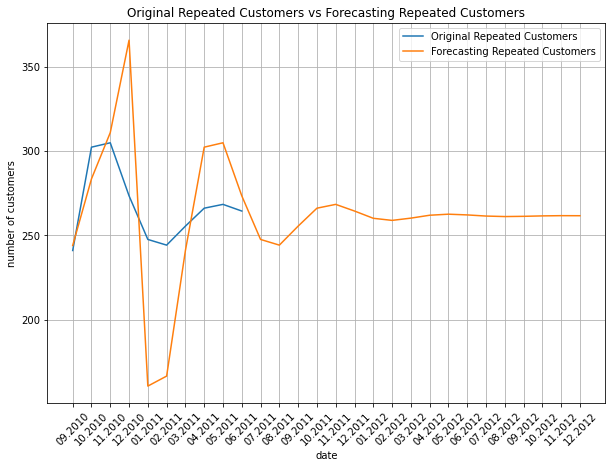

In [164]:
# Original Repeated Customers vs Forecasting Repeated Customers
# Number of Repeated Purchase by a Customers (NR Purchase by )
ax = pd.DataFrame(predicted.values).plot(
    figsize = (10,7)
)

pd.DataFrame(forcast_by_21_9.values).plot(
    ax = ax, grid = True
)

ax.set_xlabel('date')
ax.set_ylabel('number of customers')
ax.set_title('Original Repeated Customers vs Forecasting Repeated Customers')

ax.legend(['Original Repeated Customers', 'Forecasting Repeated Customers'])

plt.xticks(
    range(len(forcast_by_21_9.index)),
    [x.strftime('%m.%Y') for x in forcast_by_21_9.index],
    rotation = 45
)

plt.show()
